In [22]:
from seeg_tool import *
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import scipy.io 
import mne
import os
import sys
sys.path.insert(0, 'E:/workspace/my_py_toolbox/')
from hm_tools import *

in_roi1_path = r"E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/" # 分析哪个roi就输入哪个文件夹的数据
in_roi2_path = r"E:/workspace/sEEG_slow_fast_attack/roi_data/amy/" # 分析哪个roi就输入哪个文件夹的数据
roi_name = "vmpfc-hippo"
time_lag = np.arange(-0.3, 0.31, 0.01)
subjects = [104, 108, 116, 117, 119, 120]  # 同时有vmpfc 和 hippo   # 同时有vmpfc 和 amy  同时有vmpfc 和parahippo
# subjects = [104, 108, 113, 116, 117, 119, 120]
# subjects= [104, 108, 113, 116, 117, 119, 120, 122] # amy 115 122
# subjects = [104, 108, 109, 112, 113, 116, 117, 119, 120, 124]  # hippo 删除 107 

# subjects = [116, 119, 120, 122]
# subjects = [116, 119, 120] # vmPFC and  striatum
baseline_method = 'logratio'  # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
event1 = '1/5/6'
event2 = '3/5/6'

freqs=np.arange(70, 120, 5)
n_cycles=10
time_span = 100


def hm_mix_corr(x,y):
    import scipy
    import numpy as np

    xy = np.concatenate((x,y),axis=0)
    xy_corr = np.corrcoef(xy)
    
    return xy_corr[:x.shape[0], x.shape[0]:]


def gaussian_filter(data, time_span=50, fs=1000, axis=-1):

    # time_span: the length of the window (ms)
    from scipy import signal, ndimage

    winsize = time_span * fs / 1000

    # create a window(kernel) with value follow a gaussian distrubution
    window = signal.gaussian(winsize,std = int((winsize)/5) ) # Note! In matlab function 'gausswin',the parameter is α(defaut = 2.5), here is std, std = winsize/2α

    # Make the sum of the window = 1
    gusWin = window/sum(window)

    # convolve the last dimension
    data_filtered = ndimage.convolve1d(input=data, weights=gusWin, axis=axis, mode='nearest', origin=0)

    return data_filtered


In [24]:
# calculate the HGA of roi1
from mne.time_frequency import tfr_morlet

ROI1_fast={}
ROI1_slow={}
for i in range(len(subjects)):


    ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')
    
    # 
    if subjects[i]==108:
        ROI_epochs.events[61, 2] = 3
    if subjects[i]==119:
        ROI_epochs.events[49, 2] = 1
    if subjects[i]==109:
        ROI_epochs.events[4, 2] = 1

    tfr_ROI_epoch_fast = tfr_morlet(ROI_epochs[event1], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)
    tfr_ROI_epoch_slow = tfr_morlet(ROI_epochs[event2], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)

    tfr_ROI_epoch_fast.apply_baseline(mode=baseline_method, baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
    tfr_ROI_epoch_slow.apply_baseline(mode=baseline_method, baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'

    smooth_hgb_fast_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_fast.data,axis=2), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    smooth_hgb_slow_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_slow.data,axis=2), time_span=time_span, fs=ROI_epochs.info['sfreq'])

    # 
    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)

    all_smooth_hgb_fast = mne.EpochsArray(data = smooth_hgb_fast_data, info = info, tmin=-0.5)
    all_smooth_hgb_slow = mne.EpochsArray(data = smooth_hgb_slow_data, info = info, tmin=-0.5)

    all_smooth_hgb_fast_crop = all_smooth_hgb_fast
    all_smooth_hgb_slow_crop = all_smooth_hgb_slow

    all_smooth_hgb_fast_crop = all_smooth_hgb_fast_crop.crop(-0.0, 1.0)
    all_smooth_hgb_slow_crop = all_smooth_hgb_slow_crop.crop(-0.0, 1.0)
    
    ROI1_fast[subjects[i]] = all_smooth_hgb_fast_crop
    ROI1_slow[subjects[i]] = all_smooth_hgb_slow_crop

Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/104.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/108.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/116.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/117.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/119.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/vmpfc/120.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-24-31e195fab75a>:8: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi1_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [25]:
from mne.time_frequency import tfr_morlet


ROI2_fast={}
ROI2_slow={}
for i in range(len(subjects)):


    ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')

    # 先分别提取
    if subjects[i]==108:
        ROI_epochs.events[61, 2] = 3
    if subjects[i]==119:
        ROI_epochs.events[49, 2] = 1
    if subjects[i]==109:
        ROI_epochs.events[4, 2] = 1
        
    tfr_ROI_epoch_fast = tfr_morlet(ROI_epochs[event1], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)
    tfr_ROI_epoch_slow = tfr_morlet(ROI_epochs[event2], freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)

    tfr_ROI_epoch_fast.apply_baseline(mode=baseline_method, baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
    tfr_ROI_epoch_slow.apply_baseline(mode=baseline_method, baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'

    smooth_hgb_fast_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_fast.data,axis=2), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    smooth_hgb_slow_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_slow.data,axis=2), time_span=time_span, fs=ROI_epochs.info['sfreq'])

    info = mne.create_info(ch_names = ROI_epochs.ch_names, ch_types = 'eeg', sfreq = 1000)

    all_smooth_hgb_fast = mne.EpochsArray(data = smooth_hgb_fast_data, info = info, tmin=-0.5)
    all_smooth_hgb_slow = mne.EpochsArray(data = smooth_hgb_slow_data, info = info, tmin=-0.5)


    all_smooth_hgb_fast_crop = all_smooth_hgb_fast
    all_smooth_hgb_slow_crop = all_smooth_hgb_slow

    all_smooth_hgb_fast_crop = all_smooth_hgb_fast_crop.crop(-0.0, 1.0)
    all_smooth_hgb_slow_crop = all_smooth_hgb_slow_crop.crop(-0.0, 1.0)
    
    ROI2_fast[subjects[i]] = all_smooth_hgb_fast_crop
    ROI2_slow[subjects[i]] = all_smooth_hgb_slow_crop

Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/104.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


Not setting metadata


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/108.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/116.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/117.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/119.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/120.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-25-0afc1513d223>:9: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_roi2_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


# Group level analysis


In [26]:
FC_fast, FC_slow = {}, {}
for i in range(len(subjects)):

    # Extract data first
    iters_roi1_fast = ROI1_fast[subjects[i]]
    iters_roi1_slow = ROI1_slow[subjects[i]]
    iters_roi2_fast = ROI2_fast[subjects[i]]
    iters_roi2_slow = ROI2_slow[subjects[i]]

    iters_roi1_fast_data = ROI1_fast[subjects[i]].get_data()  # trial * electrodes * time
    iters_roi1_slow_data = ROI1_slow[subjects[i]].get_data()
    iters_roi2_fast_data = ROI2_fast[subjects[i]].get_data()
    iters_roi2_slow_data = ROI2_slow[subjects[i]].get_data()

    fast_iter_sub_fc=[]
    slow_iter_sub_fc=[]
    for iter_time_lag in time_lag:  # vmpfc>hippo 
        # Left and right moving data points
        iter_time_lag_point = int(iter_time_lag * 1000)
        if iter_time_lag < 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data[:,:,abs(iter_time_lag_point):]            
        elif iter_time_lag == 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data
        elif iter_time_lag > 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
        
        # Afterwards, it will be divided into two conditions: fast and slow
        # fast condition
        iter_tl_fast_fc = []
        for iter_trial in range(iter_time_lag_roi2_fast_data.shape[0]):
            iter_tl_fast_fc.append(hm_mix_corr(iter_time_lag_roi1_fast_data[iter_trial],iter_time_lag_roi2_fast_data[iter_trial]))
        iter_tl_fast_fc = np.mean(np.array(iter_tl_fast_fc), axis=0).flatten()

        # slow condition
        iter_tl_slow_fc = []
        for iter_trial in range(iter_time_lag_roi2_slow_data.shape[0]):
            iter_tl_slow_fc.append(hm_mix_corr(iter_time_lag_roi1_slow_data[iter_trial],iter_time_lag_roi2_slow_data[iter_trial]))
        iter_tl_slow_fc = np.mean(np.array(iter_tl_slow_fc), axis=0).flatten()

        fast_iter_sub_fc.append(iter_tl_fast_fc)  
        slow_iter_sub_fc.append(iter_tl_slow_fc)


    
    fast_iter_sub_fc = np.array(fast_iter_sub_fc).transpose()
    slow_iter_sub_fc = np.array(slow_iter_sub_fc).transpose()

    FC_fast[subjects[i]] = fast_iter_sub_fc  # timelag * trials * roi1 * roi2
    FC_slow[subjects[i]] = slow_iter_sub_fc

In [137]:
fast_iter_sub_fc.shape

(195, 101)

In [27]:
# All data is extracted side by side
FC_fast_data, FC_slow_data = [], []
for i in range(len(subjects)):
    print(FC_fast[subjects[i]].shape)
    if i == 0:
        FC_fast_data, FC_slow_data = FC_fast[subjects[i]], FC_slow[subjects[i]]
    else:
        FC_fast_data = np.vstack((FC_fast_data, FC_fast[subjects[i]]))
        FC_slow_data = np.vstack((FC_slow_data, FC_slow[subjects[i]]))

(6, 61)
(15, 61)
(60, 61)
(100, 61)
(168, 61)
(234, 61)


In [28]:
# create a new epochs info
info = mne.create_info(ch_names = list((np.arange(FC_fast_data.shape[0])).astype('str')), ch_types = 'eeg', sfreq = 100)

# create a new ROI based epochs
FC_fast_data = mne.EvokedArray(data = FC_fast_data, info = info, tmin=-0.3)
FC_slow_data = mne.EvokedArray(data = FC_slow_data, info = info, tmin=-0.3)


n_permutations = 10000

# Significance relative to 0 in two conditions
T_obs_fast, clusters_fast, cluster_p_values_fast, H0_fast  = mne.stats.permutation_cluster_1samp_test(FC_fast_data.data, 
                                                    out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)

T_obs_slow, clusters_slow, cluster_p_values_slow, H0_slow  = mne.stats.permutation_cluster_1samp_test(FC_slow_data.data, 
                                                    out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)


# The significance between the two conditions
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([FC_fast_data.data, FC_slow_data.data],
                                                                out_type='mask', n_permutations=n_permutations, n_jobs=4,tail=0
                                                                ,verbose=None, t_power=1)



Using a threshold of 1.964048
stat_fun(H1): min=-5.067175 max=14.772122
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:02<00:00, 4773.01it/s]

Computing cluster p-values
Done.


Using a threshold of 1.964048
stat_fun(H1): min=-8.750787 max=24.051769
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 5200.80it/s]


Computing cluster p-values
Done.
Using a threshold of 3.849460
stat_fun(H1): min=0.003502 max=89.761699
Running initial clustering
Found 5 clusters


<ipython-input-28-b3aeaddf90ce>:23: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([FC_fast_data.data, FC_slow_data.data],


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:02<00:00, 3775.63it/s]

Computing cluster p-values
Done.


In [16]:
cluster_p_values_slow

array([1.000e-04, 4.848e-01])

<ipython-input-29-b47bc58d2faa>:119: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(r'D:\Desktop\项目\seeg\画图\FC\vmpfc_amy_stimuli.jpg',dpi=300, overwrite=True)


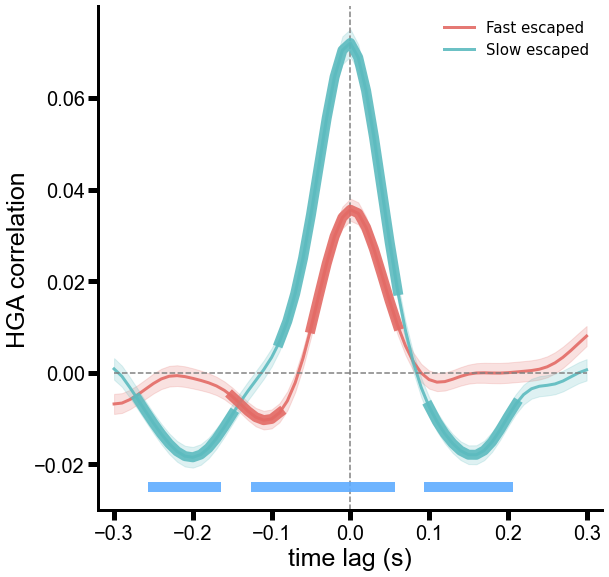

In [29]:
line_color = ['#E36A65','#5CBBBF']    # 红色湖蓝色 正确快攻击，正确慢攻击 
# line_color = ['#E36A65','#FF943C']    # 红色橙色 正确快攻击，错误快攻击  DE6B48  FFADC6
# line_color = ['#5CBBBF','#4482CD']    #  正确慢攻击，过快慢攻击  DE6B48  FFADC6
# line_color = ['#FF943C','#4482CD']    #  错误快攻击，过快慢攻击  DE6B48  FFADC6

figsize=(10,10) 
title_size=20
legend_size=15

ticksize=10
subplots_adjust=[0.15, 0.15, 0.85, 0.85]


import matplotlib.pyplot as plt
import numpy as np
import os


event_0_line_color = line_color[0]
event_1_line_color = line_color[1]

# the number of time axis
times = FC_fast_data.times

plt.close('all')
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
# plt.title('ROI: '+ roi_name, fontdict={'fontsize':title_size})

epoch_mean={}
epoch_mean[0] = np.squeeze(np.average(FC_fast_data.data, axis=0))
epoch_mean[1] = np.squeeze(np.average(FC_slow_data.data, axis=0))

# epoch_mean[0] = FC_fast_data.data[500]
# epoch_mean[1] = FC_slow_data.data[500]

plt.plot(times, epoch_mean[0], color=line_color[0], alpha=0.9, linewidth=3) # , linestyle='--')
plt.plot(times, epoch_mean[1], color=line_color[1], alpha=0.9, linewidth=3) # , linestyle='--')


# Draw the dividing line at 0s 
plt.axvline(0, c="gray", ls = "dashed")

plt.plot(times, np.zeros(len(epoch_mean[0])), color="gray", linestyle="--")

# Drawing error (std)
std_event0 = np.squeeze(np.std(FC_fast_data.data, axis=0))
std_event1 = np.squeeze(np.std(FC_slow_data.data, axis=0))

se_event0 = std_event0/np.sqrt(FC_fast_data.data.shape[0])
se_event1 = std_event1/np.sqrt(FC_slow_data.data.shape[0])

plt.fill_between(times, epoch_mean[0] - se_event0, epoch_mean[0] + se_event0, color=line_color[0], alpha=0.2)
plt.fill_between(times, epoch_mean[1] - se_event1, epoch_mean[1] + se_event1, color=line_color[1], alpha=0.2)

# The significance of event 0
for i_c, c in enumerate(clusters_fast):
    c = c[0]
    if cluster_p_values_fast[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[0][c.start : c.stop-1], color=event_0_line_color, alpha=0.9, linewidth=10)
# The significance of event 1
for i_c, c in enumerate(clusters_slow):
    c = c[0]
    if cluster_p_values_slow[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[1][c.start : c.stop-1], color=event_1_line_color, alpha=0.9, linewidth=10)

# Significance between events
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        
        plt.plot(times[c.start : c.stop - 1], -0.025 * np.ones(len(epoch_mean[0]))[c.start : c.stop-1], color='#5EACFF', alpha=0.9, linewidth=10)


plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3], hspace=0.1,wspace=0.1)

plt.xlim([times[0]-0.02, times[-1]+0.02])

plt.yticks(size=ticksize)
plt.xticks(size=ticksize)

spines_width = 3
ax=plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(spines_width)
ax.spines['bottom'].set_linewidth(spines_width)
# sns.despine()

# Axis scale thickness, facing inward
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# plt.set_ylabel("Escape Accuracy", size=ticksize, fontproperties='Arial')

labelsize=25
plt.xlabel("time lag (s)", fontsize=labelsize, fontproperties='Arial')
plt.ylabel("HGA correlation", size=labelsize, fontproperties='Arial')

# The thickness of coordinates
ticksize = 20
plt.yticks(size=ticksize, fontproperties='Arial')
plt.xticks(size=ticksize, fontproperties='Arial')
# plt.savefig(r'D:\Desktop\项目\seeg\画图\FC\vmpfc_amy_stimuli.jpg',dpi=300, overwrite=True)

# plt.savefig(result_path + '/' + permutation_cluster_result['ROI_name'][ROI_num] + ".png", overwrite=True)

# Analysis of the situation of each electrode pair


In [30]:
# Preserve the functional connection strength of each trial and calculate the significance of each electrode pair

FC_fast, FC_slow = {}, {}
ROI_1, ROI_2 = {}, {}
for i in range(len(subjects)):

    # 先提取数据
    iters_roi1_fast = ROI1_fast[subjects[i]]
    iters_roi1_slow = ROI1_slow[subjects[i]]
    iters_roi2_fast = ROI2_fast[subjects[i]]
    iters_roi2_slow = ROI2_slow[subjects[i]]

    iters_roi1_fast_data = ROI1_fast[subjects[i]].get_data()  # trial * electrodes * time
    iters_roi1_slow_data = ROI1_slow[subjects[i]].get_data()
    iters_roi2_fast_data = ROI2_fast[subjects[i]].get_data()
    iters_roi2_slow_data = ROI2_slow[subjects[i]].get_data()

    fast_iter_sub_fc=[]
    slow_iter_sub_fc=[]
    for iter_time_lag in time_lag:  # vmpfc>hippo 是正的
        # 左右移动的数据点
        iter_time_lag_point = int(iter_time_lag * 1000)
        if iter_time_lag < 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data[:,:,abs(iter_time_lag_point):]            
        elif iter_time_lag == 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data
        elif iter_time_lag > 0:
            iter_time_lag_roi1_fast_data = iters_roi1_fast_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi1_slow_data = iters_roi1_slow_data[:,:,abs(iter_time_lag_point):]
            iter_time_lag_roi2_fast_data = iters_roi2_fast_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
            iter_time_lag_roi2_slow_data = iters_roi2_slow_data[:,:,0:iters_roi2_fast_data.shape[-1]-abs(iter_time_lag_point)]
        
        # Afterwards, it will be divided into two conditions: fast and slow
        # fast condition
        iter_tl_fast_fc = []
        for iter_trial in range(iter_time_lag_roi1_fast_data.shape[0]):
            iter_tl_fast_fc.append(hm_mix_corr(iter_time_lag_roi1_fast_data[iter_trial],iter_time_lag_roi2_fast_data[iter_trial]))
        iter_tl_fast_fc = np.array(iter_tl_fast_fc)

        # slow condition
        iter_tl_slow_fc = []
        for iter_trial in range(iter_time_lag_roi1_slow_data.shape[0]):
            iter_tl_slow_fc.append(hm_mix_corr(iter_time_lag_roi1_slow_data[iter_trial],iter_time_lag_roi2_slow_data[iter_trial]))
        iter_tl_slow_fc = np.array(iter_tl_slow_fc)

        fast_iter_sub_fc.append(iter_tl_fast_fc)  
        slow_iter_sub_fc.append(iter_tl_slow_fc)

    fast_iter_sub_fc = np.array(fast_iter_sub_fc)
    slow_iter_sub_fc = np.array(slow_iter_sub_fc)

    FC_fast[subjects[i]] = fast_iter_sub_fc  # timelag * trials * roi1 * roi2
    FC_slow[subjects[i]] = slow_iter_sub_fc

    # Calibrate the names of each electrode for two electrodes
    roi1_ch_name = iters_roi1_slow.ch_names
    roi2_ch_name = iters_roi2_slow.ch_names

    ROI_1[subjects[i]] = np.transpose([roi1_ch_name] * len(roi2_ch_name))
    ROI_2[subjects[i]] = np.array([roi2_ch_name] * len(roi1_ch_name))


In [134]:
roi1_ch_name = iters_roi1_slow.ch_names
roi2_ch_name = iters_roi2_slow.ch_names

In [31]:
from scipy.stats import ttest_1samp

n_permutations = 10000

all_permutation_df_fast = {}
all_permutation_df_fast['subject']=[]
all_permutation_df_fast['channel_number']=[]
all_permutation_df_fast['max_value_timepoint']=[]
all_permutation_df_fast['max-value']=[]
all_permutation_df_fast['roi_1']=[]
all_permutation_df_fast['roi_2']=[]

all_permutation_df_slow = {}
all_permutation_df_slow['subject']=[]
all_permutation_df_slow['channel_number']=[]
all_permutation_df_slow['max_value_timepoint']=[]
all_permutation_df_slow['max-value']=[]
all_permutation_df_slow['roi_1']=[]
all_permutation_df_slow['roi_2']=[]
for i in range(len(subjects)):

    FC_fast_data, FC_slow_data = FC_fast[subjects[i]], FC_slow[subjects[i]]

    roi_1 = ROI_1[subjects[i]].reshape([FC_fast_data.shape[2]*FC_fast_data.shape[3]])
    roi_2 = ROI_2[subjects[i]].reshape([FC_fast_data.shape[2]*FC_fast_data.shape[3]])
    
    FC_fast_data = FC_fast_data.reshape([FC_fast_data.shape[0], FC_fast_data.shape[1], FC_fast_data.shape[2]*FC_fast_data.shape[3]])
    FC_slow_data = FC_slow_data.reshape([FC_slow_data.shape[0], FC_slow_data.shape[1], FC_slow_data.shape[2]*FC_slow_data.shape[3]])

    # fast condition
    for iter_channel in range(FC_fast_data.shape[-1]):
        
        iterelectrode_data = FC_fast_data[:,:,iter_channel]
        iterelectrode_data = iterelectrode_data.transpose()

        # Significance relative to 0 
        T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data, 
                                                            out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)

        if cluster_p_values.size > 0:
            for i_c, c in enumerate(clusters):
                c = c[0]
                if cluster_p_values[i_c] <= 0.05:
                    
                    cluster_iterelectrode_data = iterelectrode_data[:, c.start : c.stop - 1]
                    if np.mean(cluster_iterelectrode_data)>0:
                        all_permutation_df_fast['subject'].append(subjects[i])
                        all_permutation_df_fast['channel_number'].append(iter_channel)
                        all_permutation_df_fast['max_value_timepoint'].append(time_lag[np.argmax(np.mean(cluster_iterelectrode_data,axis=0)) + c.start])   # position
                        all_permutation_df_fast['max-value'].append(np.max(np.mean(cluster_iterelectrode_data,axis=0)))
                        all_permutation_df_fast['roi_1'].append(roi_1[iter_channel])
                        all_permutation_df_fast['roi_2'].append(roi_2[iter_channel])
                    if np.mean(cluster_iterelectrode_data)<0:
                        all_permutation_df_fast['subject'].append(subjects[i])
                        all_permutation_df_fast['channel_number'].append(iter_channel)
                        all_permutation_df_fast['max_value_timepoint'].append(time_lag[np.argmin(np.mean(cluster_iterelectrode_data,axis=0)) + c.start])   # position
                        all_permutation_df_fast['max-value'].append(np.min(np.mean(cluster_iterelectrode_data,axis=0)))
                        all_permutation_df_fast['roi_1'].append(roi_1[iter_channel])
                        all_permutation_df_fast['roi_2'].append(roi_2[iter_channel])
    # slow condition
    for iter_channel in range(FC_slow_data.shape[-1]):
        
        iterelectrode_data = FC_slow_data[:,:,iter_channel]
        iterelectrode_data = iterelectrode_data.transpose()

        # Significance relative to 0
        T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data, 
                                                            out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)

        if cluster_p_values.size > 0:
            for i_c, c in enumerate(clusters):
                c = c[0]
                if cluster_p_values[i_c] <= 0.05:
                    
                    cluster_iterelectrode_data = iterelectrode_data[:,c.start : c.stop - 1]
                    if np.mean(cluster_iterelectrode_data)>0:
                        all_permutation_df_slow['subject'].append(subjects[i])
                        all_permutation_df_slow['channel_number'].append(iter_channel)
                        all_permutation_df_slow['max_value_timepoint'].append(time_lag[np.argmax(np.mean(cluster_iterelectrode_data,axis=0)) + c.start])   # position
                        all_permutation_df_slow['max-value'].append(np.max(np.mean(cluster_iterelectrode_data,axis=0)))
                        all_permutation_df_slow['roi_1'].append(roi_1[iter_channel])
                        all_permutation_df_slow['roi_2'].append(roi_2[iter_channel])                    
                    if np.mean(cluster_iterelectrode_data)<0:
                        all_permutation_df_slow['subject'].append(subjects[i])
                        all_permutation_df_slow['channel_number'].append(iter_channel)
                        all_permutation_df_slow['max_value_timepoint'].append(time_lag[np.argmin(np.mean(cluster_iterelectrode_data,axis=0)) + c.start])   # position
                        all_permutation_df_slow['max-value'].append(np.min(np.mean(cluster_iterelectrode_data,axis=0)))
                        all_permutation_df_slow['roi_1'].append(roi_1[iter_channel])
                        all_permutation_df_slow['roi_2'].append(roi_2[iter_channel])

Using a threshold of 2.026192
stat_fun(H1): min=-0.822108 max=1.406744
Running initial clustering
Found 0 clusters
Using a threshold of 2.026192
stat_fun(H1): min=-2.320730 max=2.706358
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7899.03it/s]

Computing cluster p-values
Done.


Using a threshold of 2.026192
stat_fun(H1): min=-0.923899 max=1.779419
Running initial clustering
Found 0 clusters
Using a threshold of 2.026192
stat_fun(H1): min=-1.832423 max=2.190004
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8385.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.026192
stat_fun(H1): min=-2.079732 max=1.523268
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8341.23it/s]


Computing cluster p-values
Done.
Using a threshold of 2.026192
stat_fun(H1): min=-2.567326 max=1.113097
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8022.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.793876 max=1.574910
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.640296 max=1.264806
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.923496 max=2.316249
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 8012.42it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.448761 max=4.852063
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7895.64it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.765159 max=6.758104
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10685.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.892722 max=5.471690
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10300.73it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.049593 max=0.555463
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9806.62it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.621848 max=1.365876
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-3.636516 max=2.720009
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10123.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.819741 max=0.344405
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.098310 max=2.479744
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9782.17it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.964280 max=1.972631
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7082.51it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.099991 max=1.823930
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 6818.37it/s]

Computing cluster p-values
Done.


Using a threshold of 2.045230
stat_fun(H1): min=-1.673386 max=1.258938
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.479845 max=1.760417
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10427.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.862401 max=5.231094
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7789.82it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.798013 max=6.060103
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7894.69it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.841806 max=4.513209
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8238.93it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.755059 max=2.305283
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8229.95it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.560871 max=3.489406
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8638.22it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.889768 max=4.954269
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7494.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.984121 max=2.634879
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8119.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.727559 max=2.955995
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10119.60it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.635909 max=3.922411
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8418.83it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.728291 max=3.947025
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9515.29it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.068187 max=3.325257
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9583.30it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.788412 max=3.697055
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9164.19it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.036933
stat_fun(H1): min=-3.111287 max=1.572615
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9128.05it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-4.319102 max=1.990150
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9741.64it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-3.959005 max=3.356889
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9346.67it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.857573 max=5.424597
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11085.98it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.975313 max=4.829408
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11373.86it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.859265 max=5.322250
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10575.33it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.992012 max=3.109257
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10411.86it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-2.207689 max=3.302166
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11858.43it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.874438 max=4.873270
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11068.54it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.619809 max=2.066463
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10559.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.572600 max=1.239968
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-3.418690 max=1.380720
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11299.27it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.160983 max=2.007335
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11219.96it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.227633 max=2.416921
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10814.71it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.642954 max=2.283903
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10801.54it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.937054 max=1.283650
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.045135 max=2.011055
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10457.07it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.300492 max=2.160731
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11942.07it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-2.357588 max=3.287246
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10843.67it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-2.138941 max=1.658746
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10958.90it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.289117 max=1.362340
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10967.23it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.862427 max=1.919208
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-2.479475 max=1.911609
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11383.23it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.734399 max=1.182767
Running initial clustering
Found 0 clusters


Using a threshold of 2.032245
stat_fun(H1): min=-2.635009 max=0.841303
Running initial clustering


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10896.30it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.331128 max=1.266168
Running initial clustering
Found 0 clusters


Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.807686 max=1.476557
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.656313 max=2.326046
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10624.88it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-1.880098 max=3.341195
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10994.14it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.913657 max=1.354831
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10767.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.424998 max=1.096569
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11059.14it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-1.829374 max=1.174997
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.565825 max=1.871630
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10862.93it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.508256 max=2.141311
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11021.96it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.133038 max=0.590857
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10704.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.103681 max=2.602341
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10961.42it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.216930 max=0.869575
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10471.03it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.498793 max=0.856292
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10972.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.628852 max=0.733528
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11293.25it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.314902 max=1.085370
Running initial clustering
Found 0 clusters


Using a threshold of 2.032245
stat_fun(H1): min=-2.940980 max=1.522999
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10296.03it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.224296 max=1.681072
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11345.14it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.427803 max=3.691445
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10988.92it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.932053 max=1.894427
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.749744 max=1.742195
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.325785 max=2.164861
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11394.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.273172 max=1.881785
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-0.983615 max=1.861827
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.510912 max=2.327909
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9436.31it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.017877 max=1.432249
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.042347 max=1.242750
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10251.79it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.669223 max=1.263905
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10868.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.525044 max=1.801233
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.599541 max=0.745862
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10947.37it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.365640 max=2.855840
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10420.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.901383 max=1.368933
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.302704 max=1.693146
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.472244 max=0.938582
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-2.461380 max=1.191879
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11202.85it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.191484 max=0.669763
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9703.33it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.504925 max=2.272433
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7776.31it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.310439 max=1.555196
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.271473 max=1.771280
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-0.921586 max=2.591175
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8009.87it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.272586 max=2.367779
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11381.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.551533 max=1.129568
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.473270 max=2.281593
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11148.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.118277 max=2.256038
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11467.78it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.557116 max=3.582668
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10920.95it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-0.536473 max=1.801747
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.258367 max=2.471608
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11286.40it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.912736 max=2.016600
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11769.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.150397 max=1.519757
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.940839 max=1.625154
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-2.517425 max=1.564797
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10309.22it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.926547 max=1.450777
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.747897 max=2.445057
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7716.32it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.397933 max=2.601641
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9226.26it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.827941 max=1.799494
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.452682 max=1.132813
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-0.613626 max=1.682384
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.045230
stat_fun(H1): min=-3.127393 max=1.593080
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10074.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.431564 max=1.864566
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.885656 max=1.308797
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.851967 max=3.229934
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10244.83it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.600916 max=2.079896
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11109.73it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-0.557651 max=1.178205


Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.757597 max=2.412250
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11993.76it/s]

Computing cluster p-values
Done.


Using a threshold of 2.045230
stat_fun(H1): min=-0.837488 max=1.557452
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-2.835022 max=1.029427
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11056.73it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.296827 max=1.404143
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10554.14it/s]

Computing cluster p-values


Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.578961 max=2.070970
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11253.51it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.641378 max=1.851249
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.354244 max=2.131403
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11052.26it/s]

Computing cluster p-values
Done.


Using a threshold of 2.045230
stat_fun(H1): min=-1.257931 max=2.040318
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.384949 max=0.844794
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.656320 max=2.351384
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11723.18it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.102229 max=1.459906
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.531947 max=3.075498
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10909.41it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-3.654262 max=3.105669
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11056.69it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.330153 max=2.004745
Running initial clustering
Found 0 clusters


Using a threshold of 2.045230


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.417662 max=3.422680
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11362.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.236657 max=2.180343
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10502.55it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.803336 max=2.436038
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9361.96it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.446143 max=3.245146
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11331.21it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.358088 max=0.784304
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10684.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.264728 max=1.184520
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-2.317669 max=1.673880
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10950.40it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-0.767816 max=2.252685
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11920.45it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230


stat_fun(H1): min=-1.547890 max=1.947777
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-2.257165 max=1.683691
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11195.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.183640 max=3.150575
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10796.17it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230


stat_fun(H1): min=-1.384632 max=1.128346
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.205296 max=0.990653
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-2.421074 max=2.678688
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10559.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.530020 max=1.586768
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11318.58it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-0.476014 max=2.096585
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10328.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.634235 max=2.052058
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11287.61it/s]

Computing cluster p-values


Done.
Using a threshold of 2.045230
stat_fun(H1): min=-2.438712 max=2.174646
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11460.80it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230


stat_fun(H1): min=-0.968377 max=1.448036
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.418175 max=1.608846
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-0.433888 max=1.831175
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.045230
stat_fun(H1): min=-1.349929 max=2.502098
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10793.27it/s]

Computing cluster p-values
Done.
Using a threshold of 2.045230
stat_fun(H1): min=-1.117715 max=0.956444
Running initial clustering
Found 0 clusters


Using a threshold of 2.045230
stat_fun(H1): min=-1.483924 max=2.352881
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9662.73it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.045230
stat_fun(H1): min=-1.032135 max=1.416226
Running initial clustering
Found 0 clusters
Using a threshold of 2.045230
stat_fun(H1): min=-1.235784 max=1.475048
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.045230
stat_fun(H1): min=-1.906803 max=1.877188
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.045230
stat_fun(H1): min=-0.832987 max=1.940428
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.300647 max=1.539282
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8095.18it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.907459 max=1.266163
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.211007 max=1.356627
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.519711 max=1.668128
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.559857 max=1.392774
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11419.86it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.428327 max=3.498881
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10598.99it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.531527 max=3.268870
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12021.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.104063 max=1.638687
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.861944 max=2.819980
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9224.48it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.719331 max=2.337012
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11365.00it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.416829 max=1.439013
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.760385 max=1.938262
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.833607 max=1.646654
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-0.795101 max=1.301798
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.600999 max=1.290331
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.008431 max=1.478493
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.343908 max=2.646774
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11380.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.120745 max=1.567490
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.263045 max=1.227488
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11177.78it/s]

Computing cluster p-values
Done.


Using a threshold of 2.036933
stat_fun(H1): min=-1.017114 max=1.511408
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.911068 max=2.901142
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10418.53it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.804688 max=2.271474
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10858.36it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.513863 max=0.831798
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11695.68it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.818245 max=1.275420
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10352.22it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.449348 max=0.797050
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-3.129787 max=2.475217
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11975.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.184852 max=2.614533
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10900.25it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.348550 max=2.618983
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10190.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.112015 max=3.027611
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10043.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.907246 max=1.223405
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10183.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.658075 max=1.180133
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11393.13it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.266781 max=2.265662
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10671.43it/s]

Computing cluster p-values
Done.


Using a threshold of 2.036933
stat_fun(H1): min=-1.243732 max=2.108170
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10880.26it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.169457 max=1.798458
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9318.02it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.770968 max=1.944180
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.065379 max=1.658052
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11658.59it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.098514 max=1.093340
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.666232 max=1.592267
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.760826 max=1.140725
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.139842 max=2.301742
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10699.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.651071 max=1.856287
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933
stat_fun(H1): min=-1.958266 max=3.088952
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10752.58it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.523775 max=1.511468
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.961286 max=1.832566
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.470346 max=1.142595
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-3.545348 max=1.776096
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10913.41it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-2.013599 max=1.620381
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.129718 max=1.697252
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10482.36it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.230139 max=2.012832
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.405479 max=2.421152
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10217.17it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.569353 max=1.270092
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.892221 max=1.911209
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.621120 max=1.575177
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.197868 max=2.149113
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10438.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.284849 max=2.645161
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10312.63it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.103506 max=0.209978
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11347.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.846510 max=4.552309
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10422.59it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.352610 max=2.623679
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11134.77it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.981617 max=1.838438
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.982776 max=2.469410
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10217.09it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.443127 max=1.876566
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9742.44it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.971168 max=1.709642
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.040315 max=2.143779
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9513.87it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.665314 max=1.402721
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933
stat_fun(H1): min=-0.558552 max=1.735113
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.377514 max=2.226611
Running initial clustering


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11047.52it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.071688 max=1.271189
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.501783 max=1.995752
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.239785 max=2.521299
Running initial clustering
Found 3 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8964.99it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.202286 max=1.330243
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9847.03it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.426171 max=2.418690
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11711.95it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.933517 max=2.717043
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10717.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.961942 max=1.998698
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11834.16it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.655084 max=0.847581
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.127005 max=1.291231
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10059.33it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-3.238728 max=0.632970
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10189.92it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.689692 max=0.962298
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.156223 max=1.529844
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.726320 max=1.719977
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.062794 max=2.890132
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11738.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.131048 max=1.999169
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10867.53it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.318947 max=2.370951
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11717.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.342972 max=0.806494
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.948843 max=1.117843
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10453.39it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.385416 max=2.679569
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11114.55it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.582854 max=3.250633
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11590.50it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.415706 max=2.035639
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10085.13it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.600134 max=1.944519
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.801049 max=2.663900
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10648.18it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.778172 max=2.952353
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10913.17it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.465575 max=1.332384
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933
stat_fun(H1): min=-2.665677 max=1.669634
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11385.70it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.731913 max=1.651612
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-3.145702 max=1.750634
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10753.24it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.685534 max=1.831553
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10447.59it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.559231 max=2.414869
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11496.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.600392 max=1.540056
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.606566 max=2.662197
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10742.08it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.965469 max=2.201956


Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10331.68it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.299918 max=3.864938
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11133.23it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-1.426082 max=1.664233
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.210591 max=1.694518
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.650648 max=2.096353
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10882.33it/s]

Computing cluster p-values
Done.


Using a threshold of 2.036933
stat_fun(H1): min=-0.827453 max=2.349925
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10055.85it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.683819 max=1.258994
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.904444 max=1.625871
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.117392 max=0.362962
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.391030 max=1.554408
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 8405.75it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.646259 max=2.413622
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8967.65it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.369384 max=1.776302
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9081.86it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.269522 max=2.957894
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9676.48it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.304509 max=1.935796
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.081641 max=2.949391
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7557.62it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.620744 max=1.891060
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.757460 max=1.245741
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 6969.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.097525 max=3.146913
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7376.00it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.721572 max=1.615011
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9688.94it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.912329 max=1.715453
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933
stat_fun(H1): min=-2.022169 max=0.691675
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.535001 max=1.432823
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.108301 max=1.647426
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10182.61it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.319722 max=1.511530
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.989898 max=1.343176
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.244663 max=0.885206
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9614.41it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.729586 max=0.377692
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.120237 max=1.405153
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.168344 max=1.592104
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.251157 max=1.566664
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.428058 max=1.842979
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.866224 max=1.516107
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.008837 max=2.317196
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8766.53it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.336806 max=1.494377
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.111093 max=1.483692
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.222648 max=2.260771
Running initial clustering
Found 3 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8931.31it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.400125 max=1.567119
Running initial clustering
Found 0 clusters


Using a threshold of 2.036933
stat_fun(H1): min=-1.274338 max=1.489275
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.591098 max=2.507850
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8986.63it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.502646 max=2.138288
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9271.11it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-1.510995 max=1.731171
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.648778 max=2.974863
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8986.10it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.996374 max=1.557719
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.914272 max=1.718927
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.197211 max=1.385450
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9906.43it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.158054 max=2.395200
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8072.23it/s]

Computing cluster p-values
Done.


Using a threshold of 2.036933
stat_fun(H1): min=-2.484354 max=2.167667
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8838.56it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.869338 max=2.166631
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9101.15it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.126523 max=1.403914
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.779755 max=0.420657
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9291.57it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.205126 max=1.396298
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.726030 max=2.870361
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 8987.11it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.557099 max=1.399821
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.145012 max=0.659781
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.958894 max=1.917795
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-0.735203 max=1.712239
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-2.241935 max=1.174127
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10165.51it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.019788 max=3.152528
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10734.63it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.730182 max=2.144320
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10309.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.414300 max=1.692930
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.317350 max=1.582667
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.919561 max=1.023903
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.681088 max=1.312301
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.903101 max=1.481901
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.089399 max=1.681702
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.781957 max=1.765905
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-2.009553 max=1.488019
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.930106 max=1.479020
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.317068 max=1.688158
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.852664 max=3.457901
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10809.19it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-1.570594 max=2.305497
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11175.40it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.170497 max=2.163976
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11645.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.006651 max=1.902832
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.198186 max=1.406675
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.204526 max=2.003518
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-0.892920 max=2.673593
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12318.69it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933


stat_fun(H1): min=-1.704017 max=0.999996
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.602416 max=2.653113
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11387.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.935274 max=2.723532
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11940.39it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.120495 max=1.458487
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10704.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.193153 max=1.852607
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.873252 max=2.347331
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11440.49it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.076941 max=1.865661
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10898.66it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.609997 max=2.936722
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11737.50it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.566369 max=1.449887
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11325.43it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.428697 max=0.908939
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.269644 max=3.302382
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11732.93it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.233045 max=3.134258
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10988.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.016176 max=4.034358
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11305.77it/s]

Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.904782 max=1.551194


Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.453186 max=1.502186
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-0.379354 max=1.364203
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.036933
stat_fun(H1): min=-1.268298 max=2.677356
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11032.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.262196 max=2.100909
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11738.41it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.001390 max=3.215642
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11657.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.782045 max=1.527174
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.806854 max=1.430201
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933
stat_fun(H1): min=-1.199289 max=2.667139
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12197.35it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-0.974443 max=2.893587
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11107.33it/s]

Computing cluster p-values


Done.
Using a threshold of 2.036933
stat_fun(H1): min=-2.028772 max=1.928693
Running initial clustering
Found 0 clusters
Using a threshold of 2.036933


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.448397 max=2.213265
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11546.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.036933
stat_fun(H1): min=-1.888203 max=2.161613
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11410.38it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.413797 max=4.017140
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11451.53it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.114594 max=1.227429
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.556294 max=2.404432
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11101.86it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831


stat_fun(H1): min=-1.246911 max=1.788176
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.144149 max=3.222729
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11149.56it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.725852 max=2.769079
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11091.64it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.278828 max=3.038921
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9827.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.800474 max=1.665189
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-0.738340 max=2.578523
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10546.35it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.838379 max=2.788430
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12225.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.973409 max=1.466426
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.193492 max=2.546683
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11751.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.498483 max=2.140560
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11214.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.914395 max=2.797740
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11490.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.056012 max=3.629538
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11809.89it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.851713 max=3.474492
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10258.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.489156 max=1.139905
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.261383 max=2.835162
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11608.24it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.975529 max=2.040766
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.346926 max=2.159705
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9953.99it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.306621 max=2.852075
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12358.79it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.977186 max=2.193054
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10831.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.699417 max=2.573457
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11678.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-3.724891 max=2.187446
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10214.55it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.558026 max=2.695998
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10913.38it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.665855 max=2.288594
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10510.32it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831


stat_fun(H1): min=-1.581048 max=3.821291
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10170.39it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.881370 max=3.266514
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9724.38it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.547534 max=1.869031
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=0.031059 max=2.710816
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11193.48it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.435908 max=1.926797
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11028.14it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.045539 max=2.370416
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10925.31it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.343133 max=1.696929
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11280.31it/s]

Computing cluster p-values
Done.


Using a threshold of 2.051831
stat_fun(H1): min=-1.736333 max=3.129648
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11677.82it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.605855 max=1.302890
Running initial clustering
Found 0 clusters


Using a threshold of 2.051831
stat_fun(H1): min=-1.163376 max=3.487636
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11362.93it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.903040 max=2.901767
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11459.27it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.100888 max=4.524915
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10849.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.380632 max=2.317792
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11419.61it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.633193 max=3.793994
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10896.21it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.053711 max=1.965919
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.856866 max=2.528058
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10830.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.042668 max=3.380110
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11523.08it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.960390 max=2.890831
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11887.12it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.767977 max=1.429272
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.608374 max=2.771874
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11321.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.047957 max=1.260041
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.096592 max=2.687107
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 12064.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.062379 max=3.090834
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10471.60it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.303268 max=0.929357
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.250891 max=1.154704
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10616.59it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-3.079567 max=1.772534
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10050.17it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.852292 max=2.739880
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11093.69it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.179241 max=1.689187
Running initial clustering


Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10330.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.963882 max=1.743607
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.309543 max=1.818852
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.051831
stat_fun(H1): min=-3.313005 max=3.613542
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12163.41it/s]

Computing cluster p-values
Done.


Using a threshold of 2.051831
stat_fun(H1): min=-2.853361 max=2.713296
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11225.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.508363 max=2.499814
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11372.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.566479 max=2.207213
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11082.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.744951 max=1.599450
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.117929 max=2.503602
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11563.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831


stat_fun(H1): min=-1.836315 max=1.288251
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.915205 max=3.481881
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11852.33it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.103623 max=2.281775
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12045.99it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.286665 max=1.729260
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11751.16it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.843470 max=1.788725
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.670886 max=1.777131
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.273697 max=1.460251
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11562.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.689659 max=1.910473
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11335.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.661298 max=2.161418
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11397.43it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.829580 max=2.377661
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9963.94it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.811312 max=2.353570
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10580.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.348862 max=2.450391
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10871.57it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.427290 max=2.188500
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10151.28it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.984035 max=0.934741
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.346481 max=2.465440
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10575.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-3.285781 max=2.723006
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11674.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.261847 max=1.869469
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.224119 max=2.944370
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11577.33it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.064000 max=1.363136
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9866.21it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.719494 max=1.512739
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.844411 max=2.637876
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11247.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.025755 max=2.655325
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10924.72it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.553059 max=3.311572
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9819.30it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.551773 max=1.322515
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11741.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.188295 max=2.289098
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10859.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.836314 max=1.956160
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.516162 max=2.469396
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10580.44it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.845626 max=1.857942
Running initial clustering
Found 0 clusters


Using a threshold of 2.051831
stat_fun(H1): min=-2.288852 max=2.506218
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9327.57it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.861927 max=3.451560
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10872.50it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.243260 max=3.469571
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11342.87it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.417066 max=2.819570
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10195.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.702184 max=3.998453
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10760.56it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.619372 max=1.266117
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.199656 max=3.528844
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10813.24it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.087569 max=3.858311
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11712.41it/s]

Computing cluster p-values
Done.


Using a threshold of 2.051831
stat_fun(H1): min=-1.942544 max=3.790791
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9800.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.093709 max=4.150042
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9236.96it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.798493 max=1.948745
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-0.600406 max=1.591615
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-0.456118 max=3.096444
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10996.22it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.002625 max=2.095912
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10384.08it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-0.702552 max=2.161138
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10358.54it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.446732 max=2.286977
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9035.35it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.627659 max=1.922551
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.154425 max=0.951661
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10264.85it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.091864 max=1.969095
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.477837 max=0.964123
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.301258 max=2.469209
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10069.06it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.645576 max=3.499399
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11551.23it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.000899 max=2.508073
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10074.85it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.545717 max=1.948636
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.374830 max=1.765772
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9840.97it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.808011 max=1.357671
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9991.37it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-3.027291 max=1.441423
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11792.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.150917 max=3.606945
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10501.14it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.334364 max=1.934263
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.405909 max=2.526952
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11491.77it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.759951 max=2.729353
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11975.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.329248 max=1.114743
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.846501 max=3.158533
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11752.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.723968 max=2.302362
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11817.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.509940 max=1.700053
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.872112 max=2.053630
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11803.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-4.538870 max=1.967074
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10832.97it/s]

Computing cluster p-values
Done.


Using a threshold of 2.051831
stat_fun(H1): min=-3.992865 max=2.093090
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11870.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.366390 max=1.187127
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11603.98it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.381554 max=1.592135
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10822.32it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.129469 max=1.633882
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11439.43it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.767486 max=2.559852
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11725.67it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831


stat_fun(H1): min=-1.508593 max=2.057539
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11017.15it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.387591 max=2.199906
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10982.21it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.823006 max=2.405470
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11871.34it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.806350 max=1.373960
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.902653 max=2.830609
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10469.77it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.291644 max=1.905176
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.350771 max=3.361698
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11329.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.310737 max=4.208575
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11355.81it/s]

Computing cluster p-values
Done.


Using a threshold of 2.051831
stat_fun(H1): min=-1.445122 max=1.338814
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-3.131929 max=1.822390
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11039.76it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.587562 max=1.384030
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.262813 max=1.389480
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11848.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.622240 max=1.617317
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.654443 max=1.593196
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.990964 max=2.055857
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9984.61it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.590261 max=2.671687
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11906.04it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.165515 max=1.937941
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11753.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-3.020466 max=2.563138
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10780.42it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-2.644506 max=3.939650
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11345.18it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.507604 max=2.218370
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11370.88it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.385822 max=1.371268
Running initial clustering
Found 0 clusters


Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.259808 max=2.344739
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10620.90it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.317990 max=1.936025
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.615257 max=2.172941
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11612.62it/s]

Computing cluster p-values
Done.
Using a threshold of 2.051831


stat_fun(H1): min=-3.558089 max=3.138421
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10866.38it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.198502 max=1.875015
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-2.641507 max=2.144792
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11985.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.890537 max=1.818342
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.425020 max=1.875107
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-0.694231 max=1.354694
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.051831
stat_fun(H1): min=-2.527436 max=0.679663
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 12033.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.526131 max=1.592080
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-1.519640 max=1.223190
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831
stat_fun(H1): min=-3.042993 max=1.309767
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12194.81it/s]

Computing cluster p-values


Done.
Using a threshold of 2.051831
stat_fun(H1): min=-1.935600 max=0.758169
Running initial clustering
Found 0 clusters
Using a threshold of 2.051831


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.366466 max=1.669347
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11395.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.540033 max=3.264976
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9258.70it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.692330 max=5.138490
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8709.84it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.849181 max=3.527301
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9257.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.326725 max=4.445820
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9451.04it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.362500 max=1.571016
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8901.34it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.293702 max=2.329384
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9728.75it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.786103 max=3.205311
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9603.13it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.796360 max=2.794814
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8860.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.594880 max=3.417513
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9539.35it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-5.008488 max=3.208536
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9226.08it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.270040 max=3.200315
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9282.85it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.830310 max=2.711503
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9441.71it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.909929 max=3.799816
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9329.18it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.400135 max=1.804036
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.141936 max=4.072932
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9452.21it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.578319 max=3.776941
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9835.03it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.926690 max=4.572161
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9549.38it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.715174 max=1.202760
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9498.95it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-2.744949 max=1.170255
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9608.78it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.782589 max=2.535597
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9851.94it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.720948 max=3.080888
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8807.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.199775 max=3.163496
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9260.05it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.204204 max=3.900746
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9546.27it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.145293 max=1.705286
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9432.09it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-1.244278 max=2.369677
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9460.29it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.398687 max=2.657545
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10052.65it/s]

Computing cluster p-values
Done.
Using a threshold of 2.109816


stat_fun(H1): min=-2.068864 max=2.005823
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.450694 max=1.675515
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.232020 max=3.559129
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9311.64it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.266551 max=4.710911
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9909.26it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.831998 max=3.221353
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9416.03it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.377403 max=3.024864
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9349.34it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.509214 max=3.905835
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9578.76it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.420931 max=1.915404
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.153985 max=2.258899
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9585.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.743266 max=4.819617
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9602.40it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.001469 max=4.500453
Running initial clustering
Found 1 clusters
Permuting 9999 times...



100%|██████████|  : 9999/9999 [00:01<00:00, 9465.94it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.386422 max=3.389620
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9446.41it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.777143 max=2.624626
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9630.74it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.132449 max=2.606519
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9517.68it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.546231 max=2.237205
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9668.29it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.342853 max=2.371247
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8860.42it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.866765 max=4.045670
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9134.65it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.897506 max=3.506654
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8272.46it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.936256 max=2.478046
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9284.23it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.440928 max=2.285063
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9238.72it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-1.467552 max=2.760788
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9848.02it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.778702 max=2.912892
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9428.36it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.678372 max=1.903540
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.521008 max=1.941323
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.325577 max=2.504056
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9504.39it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.201645 max=1.515410
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9035.53it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.299157 max=1.386257
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9671.19it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.936904 max=1.160372
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.025975 max=2.808032
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9151.95it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.467600 max=1.432933
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.391973 max=1.647814
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.522392 max=2.419327
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9478.68it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.827412 max=1.395241
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.958148 max=1.538190
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.855227 max=1.697020
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.903401 max=2.386795
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9590.33it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.203996 max=0.979845
Running initial clustering
Found 0 clusters


Using a threshold of 2.109816
stat_fun(H1): min=-2.012745 max=4.022966
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9170.66it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.831429 max=3.106420
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9045.59it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.630992 max=1.200821
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.238180 max=1.422838
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-2.707412 max=1.169242
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9715.00it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816


stat_fun(H1): min=-1.334233 max=1.384405
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-0.345349 max=1.538540
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.499904 max=1.583496
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.008473 max=2.034919


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.249532 max=1.757260
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9205.06it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.198116 max=1.659673
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-0.685850 max=1.970510
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.935340 max=1.667930
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.239339 max=2.351091
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 7456.94it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.931097 max=1.562506
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.219103 max=1.906077
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.911273 max=1.729858
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-0.771491 max=1.416814
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-2.394978 max=2.876417
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9662.09it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.676214 max=3.179502
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9432.76it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.122289 max=2.133193
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9208.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.478263 max=1.804307
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9375.83it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.605578 max=1.991688
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-2.078020 max=1.845139
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.679791 max=2.271502
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9546.99it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-1.687749 max=1.160845
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.603595 max=2.396950
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10073.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.885711 max=1.542638
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-3.323875 max=4.567091
Running initial clustering
Found 3 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 8896.14it/s]

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-1.917635 max=2.656543
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9584.92it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.978045 max=3.094778


Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9171.26it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.668678 max=3.738804
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9305.31it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.150047 max=3.471533
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9805.07it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.802825 max=4.883243
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9633.99it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.452161 max=1.872842
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9345.06it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.209985 max=3.481684
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9427.58it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.869738 max=2.058123
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.783539 max=2.259382
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9122.50it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.869346 max=2.357593
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9100.61it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-4.014909 max=1.481575
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9244.26it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.558778 max=2.643706
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9681.65it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.449770 max=2.735776
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9085.30it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.525997 max=2.049745
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.694353 max=2.363502
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9612.99it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816


stat_fun(H1): min=-1.366730 max=1.294578
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.368920 max=2.887919
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9194.58it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.922242 max=1.852100
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.023544 max=1.742529
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.687265 max=2.898450
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9280.79it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.914546 max=1.854718
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9311.47it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.836569 max=4.832473
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9177.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.143084 max=2.945673
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9626.88it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.055736 max=2.834720
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9567.36it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.121029 max=3.225573
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10279.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.445925 max=3.176373
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9735.97it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.045441 max=2.274588
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9612.01it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.019698 max=1.631000
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.926420 max=3.839271
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8746.22it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.856383 max=4.110673
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9603.33it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.928424 max=1.962993
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.005179 max=2.457365
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9312.99it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.333154 max=4.230291
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9049.93it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.438658 max=4.107121
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9115.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.895701 max=1.502269
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.532226 max=2.271997
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8301.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.948401 max=1.811540
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.384324 max=1.784009
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.360191 max=2.072669
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-3.041147 max=3.096094
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9257.49it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.292243 max=3.694385
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9329.11it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.944391 max=1.937970
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.147805 max=1.863743
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.861478 max=1.792592
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-2.729709 max=1.913850
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9139.01it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.153346 max=2.478911
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9797.60it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.763337 max=2.482278
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9399.49it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.109816
stat_fun(H1): min=-1.763370 max=3.282897
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9151.12it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-3.501111 max=2.240312
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8950.38it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816


stat_fun(H1): min=-2.377986 max=1.047893
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9977.32it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-4.232793 max=2.238978
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9667.98it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.810314 max=2.910464
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9751.89it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-0.669867 max=3.982956
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9640.47it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.805308 max=2.084770
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.476784 max=2.616383
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9954.15it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.820470 max=1.685244
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816



<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.517543 max=1.527986
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.644823 max=1.592062
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.060469 max=1.953403
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-3.625327 max=2.376763
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9253.90it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.400402 max=2.137018
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9671.39it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.200077 max=1.458303
Running initial clustering


Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8918.72it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.426742 max=1.970025
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9544.19it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.773296 max=1.773557
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.778401 max=1.247195
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-2.039493 max=2.405836
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9465.11it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.371923 max=2.171948
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9705.95it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-2.065963 max=1.305041
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.427796 max=1.428389
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.663921 max=1.886694
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9202.33it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.109816
stat_fun(H1): min=-1.612745 max=1.890814
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-0.815325 max=1.328448
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.964361 max=1.969581
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-0.920926 max=2.104507
Running initial clustering
Found 0 clusters
Using a threshold of 2.109816
stat_fun(H1): min=-1.483115 max=1.592220
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.109816
stat_fun(H1): min=-1.659883 max=3.097910
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9400.16it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.387507 max=1.651588
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.913142 max=1.404336
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11350.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.200336 max=0.855097
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12369.86it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.219039 max=0.755093
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.046811 max=1.190993
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.313977 max=1.885451
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.424545 max=1.693310
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-0.803678 max=0.909739
Running initial clustering


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.358135 max=0.968002
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.387018 max=0.730349
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-3.556410 max=1.692686
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 12509.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.939867 max=3.192651
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11801.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.205295 max=0.903446
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.227048 max=1.778193
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.387192 max=1.733464
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.987115 max=1.158327
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.140240 max=1.368155
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12120.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.855967 max=2.378092
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12464.83it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.394288 max=0.768572


Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.762825 max=2.630515
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11241.26it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.856562 max=0.756606
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.633106 max=2.058303
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.752107 max=2.728203
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11984.56it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.562541 max=3.098820
Running initial clustering


Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11373.71it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.998993 max=0.906904
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-2.143556 max=1.157430
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11095.49it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.157475 max=1.306374
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10809.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.439192 max=2.105999
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12044.77it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.055607 max=4.172415
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11045.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.722164 max=3.998360
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12244.35it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.417637 max=1.797117
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11371.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.989150 max=1.097802
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12007.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.779814 max=1.294181
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11835.41it/s]

Computing cluster p-values
Done.


Using a threshold of 2.063899
stat_fun(H1): min=-1.718396 max=3.197541
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12133.94it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.850172 max=2.934218
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11979.75it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.374447 max=3.709587


Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11264.01it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.049079 max=0.855430
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-3.354576 max=1.080107
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 12063.72it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899


stat_fun(H1): min=-3.013459 max=1.686328
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11390.96it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.758708 max=1.442921
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.246032 max=0.532447
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12309.85it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.571028 max=0.843975
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.657290 max=2.033526
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11644.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.625723 max=2.092769
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11765.25it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.547292 max=3.264636
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10842.37it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.201597 max=2.067967
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12033.70it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.180832 max=2.329772
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11471.81it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.431887 max=1.972234
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.042571 max=1.313329
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.120058 max=1.199501
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.916783 max=1.489195
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.382554 max=1.087113
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.286172 max=1.177344
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.763035 max=1.654368
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-3.523627 max=0.723937
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11257.87it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.950499 max=2.371558


Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9906.98it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.961137 max=0.875879
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.401667 max=2.195316
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10780.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.644496 max=1.957923
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.883646 max=1.786609
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-4.496119 max=2.014579
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10987.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.882038 max=1.236297
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.619371 max=1.941888
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-0.513809 max=1.469440
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-0.858446 max=0.606312
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.389139 max=1.257973
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.436329 max=0.809637
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.677935 max=2.426470
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10975.46it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.545985 max=1.278975
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.583145 max=2.176506
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11250.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.713284 max=1.679817
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10977.20it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.634851 max=1.326773
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10491.27it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.834623 max=1.738953
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-3.506650 max=1.889466
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10244.60it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.814645 max=2.377918
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10898.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.432302 max=3.209587
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11838.69it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.748252 max=3.051784
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11130.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.764650 max=2.264302
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9789.10it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.404552 max=1.197874
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.831049 max=1.626305
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10834.98it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.405001 max=1.366612
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10149.36it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.868028 max=2.143508
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10026.94it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.176454 max=1.182039
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.538553 max=0.407355
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-0.801012 max=2.197500
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9665.69it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.181450 max=2.637102
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11038.11it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899


stat_fun(H1): min=-3.491849 max=1.835244
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11240.73it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.918171 max=1.299426
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-0.284714 max=2.591305
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11618.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.510672 max=2.022811
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.842311 max=2.381245
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10854.59it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.146387 max=1.704117
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10853.61it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.456440 max=0.803736
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10935.44it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.623641 max=0.949550
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.912970 max=1.131693
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.385066 max=1.544700
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-2.479753 max=1.375945
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10342.08it/s]

Computing cluster p-values
Done.


Using a threshold of 2.063899
stat_fun(H1): min=-1.654431 max=2.624140
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8686.74it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.939684 max=1.283210
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-0.837399 max=1.809469
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.060222 max=0.667994
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.722155 max=0.965838
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-3.113638 max=2.324628
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8151.82it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.215388 max=3.768863
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 8303.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.336899 max=1.189809
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.090142 max=1.938126
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.752143 max=0.794626
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-3.022507 max=0.641738
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9498.37it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.222419 max=2.627034
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11388.26it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.856459 max=2.456286
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10693.62it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.720677 max=0.860001
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.326926 max=1.715160
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.426505 max=2.584155
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10094.38it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.119863 max=1.354446
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.851303 max=3.052073
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10116.30it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.281150 max=3.878142
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9990.08it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.474978 max=1.665364
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11389.76it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.246808 max=2.068764
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11241.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.565395 max=2.667281
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9511.24it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.768033 max=1.868598
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-3.325317 max=2.631227
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11821.70it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.158707 max=1.657611
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11035.98it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.097529 max=0.939728
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.972017 max=0.877731
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.622292 max=1.649098
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.144338 max=1.540112
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-2.236239 max=3.919279
Running initial clustering
Found 3 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11103.87it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.651267 max=3.452058
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11463.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.819479 max=4.088769
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10331.15it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.286930 max=1.156934
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11788.01it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.417110 max=1.104391
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11213.12it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.500807 max=1.730460
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12166.96it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.050981 max=2.326576
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9120.06it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.546695 max=2.374093
Running initial clustering


Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9280.51it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.063899


stat_fun(H1): min=-3.014793 max=2.862239
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11511.86it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.547157 max=2.714142
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10316.92it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.424231 max=2.320503
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11114.42it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.835874 max=3.012214
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9695.16it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.989506 max=2.227835
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9408.07it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.099581 max=1.700795
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.323263 max=4.327428
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11879.66it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.351424 max=2.558105
Running initial clustering
Found 4 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10287.26it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.817173 max=1.606679
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10716.46it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.594558 max=1.157746
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10997.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.042524 max=1.725839
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.085381 max=1.538973


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10343.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.130944 max=2.120521
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10813.97it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.718091 max=1.730296
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-0.239424 max=1.811389
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-0.595472 max=4.006145
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11028.59it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.782442 max=1.616890
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.990535 max=3.554582
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11866.33it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.682154 max=1.508628
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.983682 max=2.658951
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11139.25it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.172059 max=2.252388
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10429.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.968282 max=1.940678
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.148038 max=2.028917
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10633.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.744803 max=2.937539
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10776.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.826291 max=1.799008
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.105976 max=3.344414
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9867.27it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.401487 max=2.005791
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-1.666131 max=1.587996
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.964613 max=2.362819
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10821.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.178807 max=1.175503
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.049532 max=0.933029
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.204744 max=1.099628
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-2.025391 max=1.622294
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.520889 max=1.252428
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11097.54it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.567335 max=1.552249
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-0.834819 max=1.224792
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.654989 max=1.957614
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.455877 max=1.807314
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-0.535142 max=1.705472
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.017073 max=1.695474
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-1.915897 max=2.302452
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11369.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.939066 max=2.277080
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10446.31it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.129323 max=1.338657
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10961.62it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.679047 max=2.511832
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10868.45it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.639668 max=1.859799
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-1.345099 max=1.505705
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-2.364210 max=2.007664
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10696.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.950862 max=2.256124
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9683.33it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.922978 max=1.776122
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10955.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.956584 max=1.087545
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-2.043013 max=0.764176
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.569959 max=0.715733
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.063899
stat_fun(H1): min=-2.088179 max=2.301753
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10760.38it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.972432 max=1.468396
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.811287 max=1.925129
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12032.92it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.208128 max=3.576964
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11453.65it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.098421 max=1.079823
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.504834 max=0.964096
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10761.06it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.170159 max=3.614316
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11167.02it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.598713 max=1.170866
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.378614 max=1.951240
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11253.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.229936 max=2.033447
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9068.62it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.012152 max=1.396676
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.681200 max=2.098371
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10894.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.481281 max=1.323515
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10612.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-4.276141 max=1.383094
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10310.65it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.332181 max=2.488684
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9780.91it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.419713 max=1.759448
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.004929 max=2.146677
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11901.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.312208 max=2.258920
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11735.95it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.531654 max=1.456687
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.735057 max=2.256238
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10944.94it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.124556 max=1.627516
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9392.92it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.187597 max=3.764349


Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9968.78it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.333432 max=2.955752
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11967.19it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.541651 max=4.004704
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11469.36it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.983824 max=1.187218
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.587246 max=1.790254
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.211986 max=2.457277
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10611.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.355918 max=1.464879
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-0.799235 max=1.049115
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.229074 max=2.146333
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10784.55it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.709129 max=1.032743
Running initial clustering
Found 0 clusters


Using a threshold of 2.063899
stat_fun(H1): min=-2.570106 max=0.883906
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10426.34it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.972046 max=1.371996
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9622.42it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.250211 max=2.510188
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10167.65it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.522828 max=1.604500
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.470160 max=2.658212
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10719.60it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.316436 max=2.417207
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10315.05it/s]

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-4.276222 max=1.814159
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9967.45it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-3.352719 max=3.203816
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10318.96it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.610755 max=2.316076
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9828.48it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.808925 max=2.763147
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10867.94it/s]

Computing cluster p-values


Done.
Using a threshold of 2.063899
stat_fun(H1): min=-0.476446 max=2.852910
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11288.61it/s]


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.508268 max=2.616229
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9539.99it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-1.322471 max=2.059854
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.643015 max=2.273923
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9714.58it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.063899
stat_fun(H1): min=-2.001667 max=1.151388
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.826004 max=1.609044
Running initial clustering
Found 0 clusters
Using a threshold of 2.063899
stat_fun(H1): min=-1.933215 max=1.834341
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-1.079969 max=1.241097
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.205483 max=1.823848
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:37: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-1.013152 max=1.273072
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.707742 max=1.556002
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9468.34it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.496311 max=1.515372
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.748860 max=1.580747
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.933649 max=2.587977
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10320.76it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.381443 max=3.238537
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11048.41it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.376708 max=3.030945
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10471.04it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.671362 max=2.020733
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9738.65it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.740099 max=0.582317
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9733.79it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.110598 max=1.785748
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9974.38it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.795055 max=2.198169
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10885.80it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.189300 max=1.320158
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.959402 max=1.867785
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.162323 max=2.913812
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10706.25it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.557061 max=1.468976
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.808043 max=1.504266
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.993920 max=0.996371
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-2.295628 max=2.843485
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:01<00:00, 9609.77it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.166913 max=1.321213
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10370.56it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.499696 max=0.878025
Running initial clustering
Found 0 clusters


Using a threshold of 2.032245
stat_fun(H1): min=-1.627966 max=1.505525
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.721068 max=1.637078
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11157.07it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.260266 max=1.658029
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10626.09it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.592789 max=1.340774
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9511.58it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.151057 max=1.682328
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10559.92it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.042971 max=1.921719
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-0.989852 max=2.380562
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10143.51it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.159983 max=2.041777


Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11753.68it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.377532 max=1.641681
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.223048 max=2.622340
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11528.42it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.098627 max=1.149437
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.591213 max=2.306732
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11010.13it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.788944 max=2.169337
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10370.01it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.781447 max=1.224557
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.881926 max=4.263317
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10864.92it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.714957 max=4.829772
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11381.87it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.843547 max=3.088257
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10903.76it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.325564 max=2.646689
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10916.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.463938 max=2.278466
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11304.90it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.018944 max=1.966758
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.620311 max=3.651336
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11711.93it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.289235 max=4.052181
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11609.30it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.236248 max=3.338011
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10417.89it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.675038 max=2.340906
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10531.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.990200 max=1.825660
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.079088 max=2.307859
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11118.76it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.530450 max=1.054539
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.316800 max=0.843649
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.652632 max=1.421947
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-1.739998 max=1.281977
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.923457 max=1.564541
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-2.871933 max=1.617311
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10558.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.804867 max=3.496597
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10353.26it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.149961 max=2.952370
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11323.27it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.936325 max=2.915082
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11115.73it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.354630 max=2.008970
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.830398 max=2.293673
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11689.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.917151 max=2.454602
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 12089.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.112770 max=1.792521
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11339.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.549955 max=1.548025
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10807.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.190134 max=1.208066
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11395.51it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.949057 max=2.572194
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11231.48it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.275821 max=1.092492
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11335.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.617042 max=1.341167
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9565.81it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.930751 max=1.789830
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.674360 max=2.028064
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.894279 max=1.083443
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-0.778432 max=2.648099
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11669.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.378776 max=1.793322
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-0.967552 max=2.273835
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 12218.53it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.972450 max=3.834436
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11384.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.152658 max=4.893974
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11196.92it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.407041 max=3.882116
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11464.52it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.134356 max=3.945186
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10547.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.042322 max=1.502742
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-0.708126 max=2.010419
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.171704 max=1.297695
Running initial clustering
Found 0 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Using a threshold of 2.032245
stat_fun(H1): min=-1.364072 max=1.276937
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-3.114003 max=1.974053
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11382.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.011059 max=1.999117
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.401919 max=1.702900
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11361.65it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.368308 max=2.053386


Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11499.10it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-4.417313 max=3.415145
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11419.62it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.167963 max=1.915620
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11139.88it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.231459 max=1.974904
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11362.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.968003 max=2.698694
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10919.15it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.257605 max=2.563068
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10952.06it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.193205 max=2.400809
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10926.29it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.508297 max=3.427231
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10983.11it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.235851 max=3.257378
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11025.21it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.782804 max=3.748159
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11491.13it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-1.384376 max=1.497143
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.146489 max=1.942046
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10889.77it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.056773 max=2.016692
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10981.47it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.359976 max=3.245535
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11052.07it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.849063 max=3.536551
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10569.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.276085 max=3.110039
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10473.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.810402 max=2.157547
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10699.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.979590 max=1.480405
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.270118 max=1.312400
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.860674 max=3.547957
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11537.53it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.886382 max=2.946726
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10054.68it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.366629 max=3.131902
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11485.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.199966 max=2.601771
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10571.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.399611 max=2.155794
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10728.78it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.673613 max=2.330386
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11021.79it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.741917 max=4.936302
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10581.70it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.700242 max=3.435980
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9566.86it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.105420 max=3.683820
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11061.31it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.394760 max=2.082720
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10006.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.089952 max=2.953245
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9837.99it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.382733 max=2.167461
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11577.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.420941 max=1.920654
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.201437 max=3.162842
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11078.36it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.567922 max=2.315965
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11306.46it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.888380 max=1.934644
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-3.133110 max=2.974682
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11099.16it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.477087 max=3.849082
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10684.88it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.918308 max=2.242750
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11167.27it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.762208 max=1.719835
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.735566 max=2.604803
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10134.19it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.986273 max=1.825773
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.967919 max=2.957440
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10666.09it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.117902 max=2.787941
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10878.43it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.591096 max=4.294936
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10411.60it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.040143 max=5.401218
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10784.69it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.402059 max=4.642886
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11109.00it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.346506 max=2.267164
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10274.37it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.132981 max=3.836934
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10982.48it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.572569 max=2.542317
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10726.46it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.187584 max=3.061823
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9044.92it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.944093 max=2.732723
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10445.55it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.498157 max=4.554494
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10226.18it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.734626 max=2.232511
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9783.86it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.196543 max=0.678978
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.442824 max=0.778270
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.082262 max=5.455638
Running initial clustering
Found 2 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11960.15it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.167416 max=4.341618
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10844.15it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-2.403862 max=5.754295
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10362.49it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-2.097702 max=6.103671
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11567.04it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.521061 max=2.740201
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9979.68it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.520404 max=3.360255
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10925.51it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.457425 max=6.626139
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10242.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.126708 max=5.578049
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10719.83it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.505920 max=5.943715
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10463.28it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.729551 max=5.056100
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10464.86it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.998731 max=2.598067
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10672.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.400315 max=2.671270
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9434.52it/s] 

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.564687 max=4.736602
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11524.86it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.352459 max=2.942730
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11225.08it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.614304 max=3.514924
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10982.09it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.209655 max=2.141866
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10729.38it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.869451 max=1.973670
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.412303 max=2.687314
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11021.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.455702 max=5.061311
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10877.23it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.939915 max=4.909176
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10402.39it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-5.918186 max=4.790845
Running initial clustering


Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9608.57it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.340022 max=4.645658
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9420.33it/s] 

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-2.594478 max=2.083158
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9835.53it/s] 

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.164190 max=2.496625
Running initial clustering
Found 3 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10925.44it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.064737 max=2.482627
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9248.43it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.752032 max=4.195834
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11698.94it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.613325 max=2.795563


Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11216.72it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.651177 max=2.696553
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11338.42it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.198094 max=2.401985
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11069.14it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.257594 max=1.429664
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-0.851191 max=2.106016
Running initial clustering
Found 1 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 11107.74it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.710192 max=2.973533
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11600.75it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.030311 max=2.673373
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11285.34it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.816864 max=0.814680
Running initial clustering
Found 0 clusters


Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.346532 max=0.510469
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11357.09it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.326930 max=0.299771
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11732.96it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.901039 max=1.517232
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-2.386916 max=2.128146
Running initial clustering
Found 2 clusters
Permuting 9999 times...


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
100%|██████████|  : 9999/9999 [00:00<00:00, 10876.05it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.942395 max=2.836921
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11497.24it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.894120 max=2.450845
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10532.00it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-1.226062 max=0.893573
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.254825 max=1.147231
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10696.79it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.664269 max=3.319184
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10590.81it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.527531 max=2.260805
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10207.06it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.229135 max=2.745293
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11556.77it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.555715 max=2.176083
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11204.71it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.356013 max=1.504285
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.574604 max=1.544917
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.759692 max=3.776398
Running initial clustering
Found 1 clusters


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11238.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.015856 max=4.956334
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11392.45it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.220293 max=3.386152
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11120.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.469289 max=3.930877
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10773.20it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.041567 max=1.150897
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.710105 max=0.906858
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-1.297126 max=5.104441
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10590.17it/s]

Computing cluster p-values
Done.


Using a threshold of 2.032245
stat_fun(H1): min=-1.671501 max=4.041856
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10006.28it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.744070 max=3.911160
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10072.35it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.134094 max=3.734865
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10234.65it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.770824 max=3.664464
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10386.91it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.354444 max=2.020545
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.811083 max=2.959667
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10832.62it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.390376 max=3.778906
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10913.50it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.067126 max=3.942399
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11493.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.952389 max=2.554111
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9987.61it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.514534 max=2.718094
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10677.63it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.977882 max=2.608745
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10357.95it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.405813 max=4.312210
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9415.63it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.305278 max=3.447152
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10695.84it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.935244 max=2.745099
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11093.98it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.200930 max=2.411681
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10516.08it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.860148 max=1.798750
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10886.03it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.357825 max=1.284882
Running initial clustering
Found 1 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9737.08it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.602333 max=6.328602
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9416.22it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.725755 max=4.583357
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9241.67it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.591158 max=2.742647
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10344.24it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.610506 max=2.875914
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10499.02it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.841397 max=3.439444
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10402.15it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.053452 max=2.595894
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10590.08it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-2.517985 max=3.401683
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9618.38it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.359540 max=2.956031
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9861.33it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.027690 max=2.596462
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10605.56it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-0.850648 max=3.928289
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11156.26it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.190907 max=1.060636
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245
stat_fun(H1): min=-1.220854 max=1.320922
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,
<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.195063 max=3.945996
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11102.64it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.172227 max=3.987725
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10174.94it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.621659 max=4.539000
Running initial clustering
Found 2 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10671.49it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.131924 max=3.051356
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10268.97it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-1.440592 max=1.850477
Running initial clustering
Found 0 clusters
Using a threshold of 2.032245


<ipython-input-31-890a97156a6f>:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0_fast  = mne.stats.permutation_cluster_1samp_test(iterelectrode_data,


stat_fun(H1): min=-2.827020 max=1.539620
Running initial clustering
Found 1 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11366.48it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.630307 max=4.129214
Running initial clustering
Found 2 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:01<00:00, 9639.58it/s] 


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.420310 max=3.818441
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10772.32it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.172434 max=3.487907
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10959.10it/s]


Computing cluster p-values
Done.
Using a threshold of 2.032245
stat_fun(H1): min=-3.278879 max=2.206144
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10159.52it/s]

Computing cluster p-values


Done.
Using a threshold of 2.032245
stat_fun(H1): min=-2.233979 max=2.427588
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 10860.26it/s]

Computing cluster p-values
Done.
Using a threshold of 2.032245


stat_fun(H1): min=-2.569588 max=4.442467
Running initial clustering
Found 3 clusters
Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:00<00:00, 11058.74it/s]

Computing cluster p-values
Done.


In [32]:
all_permutation_df_slow = pd.DataFrame(all_permutation_df_slow)
all_permutation_df_fast = pd.DataFrame(all_permutation_df_fast)
all_permutation_df_slow.to_csv(r'D:\Desktop\项目\seeg\画图\FC\all_permutation_vmpfc_amy_stimuli_slow.csv')
all_permutation_df_fast.to_csv(r'D:\Desktop\项目\seeg\画图\FC\all_permutation_vmpfc_amy_stimuli_fast.csv')

In [75]:
len(all_permutation_df_fast['channel_number'])

79

In [76]:
len(all_permutation_df_slow['channel_number'])

106

Text(58.125, 0.5, ' ')

<Figure size 720x720 with 0 Axes>

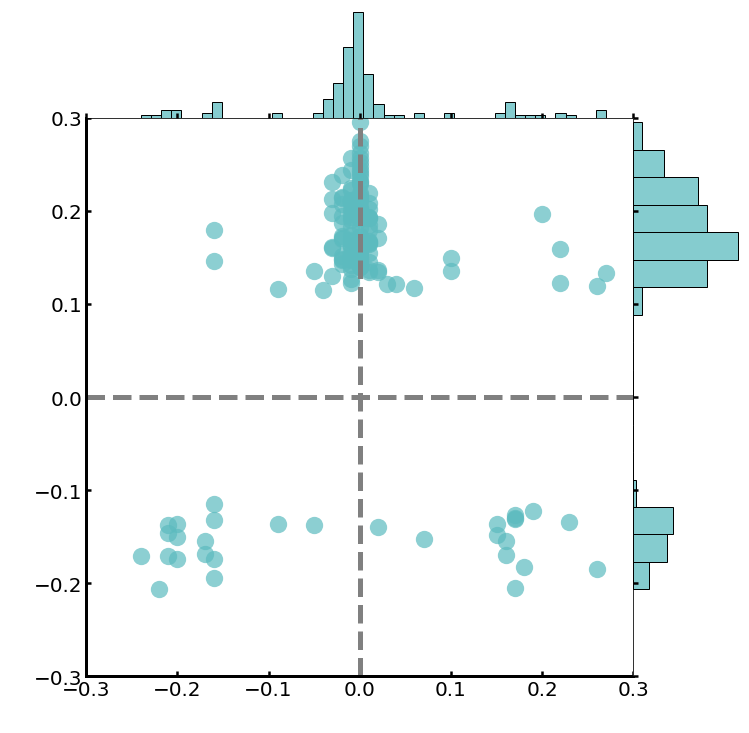

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

line_color = ['#E36A65','#5CBBBF'] 
figsize=(10,10) 
title_size=20
legend_size=15
# sns.set_context({'figure.figsize':[10, 10]})
ticksize=10
subplots_adjust=[0.15, 0.15, 0.85, 0.85]
plt.figure(figsize= figsize)

ax = sns.jointplot(data=all_permutation_df_slow, x='max_value_timepoint', y='max-value', color='#5CBBBF', kind='scatter', s=300,
                   height=10, ratio=5, space=0, dropna=False, xlim=[-0.3,0.3], ylim=[-0.3,0.3], palette=None, hue_order=None, alpha=0.7,
                   hue_norm=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, linewidth=0)
# ax.set_axis_labels(fontsize=1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 5
plt.rcParams['ytick.major.width'] = 5
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
spines_width = 3
# ax=plt.gca()
plt.axvline(0, c="gray", ls = "dashed", linewidth=5)
# plt.axvline(time_lag[31], c="gray", ls = "dashed")
plt.plot(time_lag, np.zeros(len(time_lag)), color="gray", linestyle="--",  linewidth=5)

labelsize=25

# The thickness of coordinates
ticksize = 20


spines_width = 3
bx=plt.gca()
bx.spines['top'].set_linewidth(spines_width)
bx.spines['right'].set_linewidth(spines_width)
bx.spines['left'].set_linewidth(spines_width)
bx.spines['bottom'].set_linewidth(spines_width)
# sns.despine()

labelsize=25
plt.xlabel(" ", fontsize=labelsize, fontproperties='Arial')
plt.ylabel(" ", size=labelsize, fontproperties='Arial')
# plt.savefig(r'D:\Desktop\项目\seeg\画图\FC\vmpfc_hippo_slow.jpg',dpi=300, overwrite=True)


In [ ]:
all_permutation_df_slow

Text(48.125, 0.5, ' ')

<Figure size 720x720 with 0 Axes>

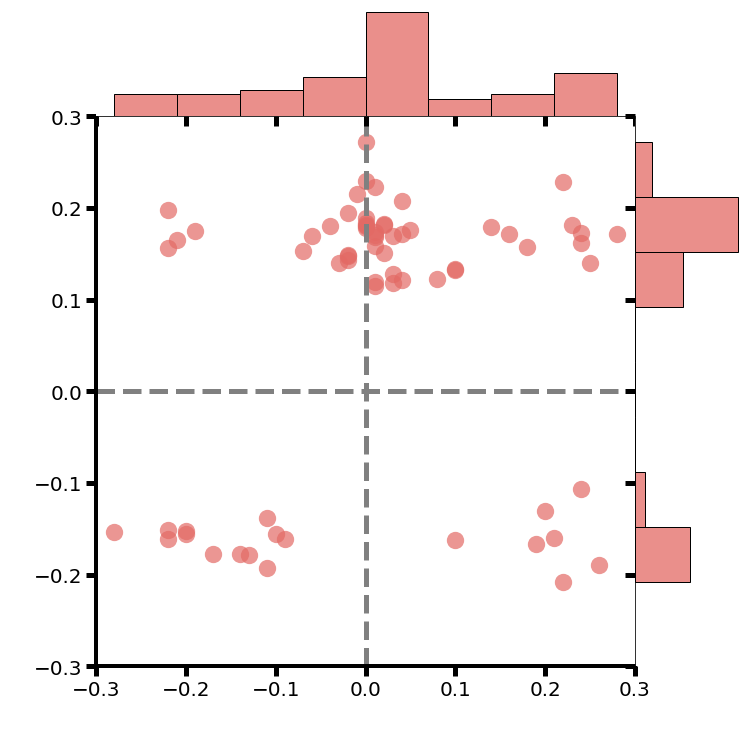

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

line_color = ['#E36A65','#5CBBBF'] 
figsize=(10,10) 
title_size=20
legend_size=15
# sns.set_context({'figure.figsize':[10, 10]})
ticksize=10
subplots_adjust=[0.15, 0.15, 0.85, 0.85]
plt.figure(figsize= figsize)

ax = sns.jointplot(data=all_permutation_df_fast, x='max_value_timepoint', y='max-value', color='#E36A65', kind='scatter', s=300,
                   height=10, ratio=5, space=0, dropna=False, xlim=[-0.3,0.3], ylim=[-0.3,0.3], palette=None, hue_order=None, alpha=0.7,
                   hue_norm=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, linewidth=0)
# ax.set_axis_labels(fontsize=1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 5
plt.rcParams['ytick.major.width'] = 5
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
spines_width = 3
# ax=plt.gca()
plt.axvline(0, c="gray", ls = "dashed", linewidth=5)
# plt.axvline(time_lag[31], c="gray", ls = "dashed")
plt.plot(time_lag, np.zeros(len(time_lag)), color="gray", linestyle="--",  linewidth=5)

labelsize=25

# The thickness of coordinates
ticksize = 20


spines_width = 4
bx=plt.gca()
bx.spines['top'].set_linewidth(spines_width)
bx.spines['right'].set_linewidth(spines_width)
bx.spines['left'].set_linewidth(spines_width)
bx.spines['bottom'].set_linewidth(spines_width)
# sns.despine()
labelsize=25
plt.xlabel(" ", fontsize=labelsize, fontproperties='Arial')
plt.ylabel(" ", size=labelsize, fontproperties='Arial')
# plt.savefig(r'D:\Desktop\项目\seeg\画图\FC\vmpfc_hippo_fast.jpg',dpi=300, overwrite=True)